<a href="https://colab.research.google.com/github/dlevonian/wine_witness/blob/master/ww_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Witness Project

In [0]:
import numpy as np
import pandas as pd

import math
from scipy import stats

import time
import os


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/NYCDSA/wine_witness/'  # Google Drive path

In [0]:
def display_stats(arr, quantiles=None, pct_values=None):
    """Helper function to calculate and display key stats for numeric array or array-like
    """
    arr = np.array(arr)
    print(f'Length    {len(arr):,}')
    print(f'Min--Max  {np.nanmin(arr)}--{np.nanmax(arr)}')
    print(f'Mean      {np.nanmean(arr):.2f}')
    print(f'Median    {np.nanmedian(arr)}')
    print(f'St.dev    {np.nanstd(arr):.2f}')
    if quantiles:
        values    = [np.quantile(arr, x) for x in quantiles]
        print('Quantiles:  ' + str(dict(zip(quantiles, values))))
    if pct_values:
        percentiles = [int(100*stats.percentileofscore(arr, x))/100 for x in pct_values]
        print('Percentiles:  ' + str(dict(zip(pct_values, percentiles))))


## Load and Preprocess

In [0]:
# fields scraped by Selenium
HEADERS =  ['wine_id',
            'url',
            'price',
            'winery',
            'vintage',
            'wine_type',
            'wine_style',
            'region',
            'country',
            'avg_rating',
            'n_ratings',
            'light_bold',
            'smooth_tannic',
            'dry_sweet',
            'soft_acidic',
            'review_1',
            'review_2',
            'review_3',
            'img_link']


In [0]:
df = pd.read_csv(os.path.join(path, 'ww_main.csv'), 
                 encoding = 'latin_1',
                 names = HEADERS,
                 index_col = 'wine_id')
df.head(2)

,url,price,winery,vintage,wine_type,wine_style,region,country,avg_rating,n_ratings,light_bold,smooth_tannic,dry_sweet,soft_acidic,review_1,review_2,review_3,img_link
wine_id,,,,,,,,,,,,,,,,,,
10,https://www.vivino.com/it-scacciadiavoli-brut-...,29.99,Scacciadiavoli,Brut Rosé Metodo Classico,Sparkling wine,NaN,Umbria,Italy,3.8,363,NaN,NaN,NaN,NaN,"Excellently balanced, a lot of mineralogy. Ver...","Light pink in color. Nose is tart cranberry, v...",Not typically a fan of ros sparkling wine. But...,https://images.vivino.com/thumbs/a_lq38qvSJ-jY...
35,https://www.vivino.com/amity-riesling/w/35,22.99,Amity,Riesling,White wine,Oregon Riesling,Willamette Valley,United States,3.6,70,37.5,NaN,25.7286,76.4179,"Lemon and honey color. Lemon curd, chalk, whit...",Very tasty wine but I liked the other Riesling...,Sleeping Beauty wishes that she had this color...,https://images.vivino.com/thumbs/lGlSDqTsQ1yNh...


In [0]:
print(df.shape)
original_length = df.shape[0]

(14404, 18)


Winery and vintage certainly have explanatory power. However we drop them from the feature columns because:
- winery is too granular: >5,000 wineries, less than 3 wine item per winery, which will definitely overfit
- vintage is also too granular (>9,00) b/c it represents specific vintage per winery. 
- In contrast, the wine_type and wine_style features are kept b/c they are not very gralunar and definitely have much explanatory power
 

In [0]:
for col in ['winery','vintage', 'wine_type', 'wine_style']:
    print(f'{col}: {len(df[col].unique())} unique')
    print(f'{df[col].value_counts()}')
    print('='*50)

winery: 5393 unique
Louis Latour                    61
Joseph Drouhin                  52
Louis Jadot                     42
Bouchard Père & Fils            35
Albert Bichot                   30
                                ..
Tussock Jumper                   1
Bacaro                           1
Château Poujeaux                 1
Château Malescot St. Exupery     1
El Libre                         1
Name: winery, Length: 5393, dtype: int64
vintage: 9076 unique
Cabernet Sauvignon                              500
Chardonnay                                      403
Pinot Noir                                      322
Sauvignon Blanc                                 260
Merlot                                          186
                                               ... 
Morey-Saint-Denis 'En la Rue de Vergy'            1
Bernkasteler Badstube Riesling Beerenauslese      1
Lumina Pinot Grigio                               1
The Heritage Collection Petite Sirah              1
La Serra Blan

In [0]:
CATEGORICAL_COLUMNS = ['wine_type', 'wine_style', 'region', 'country']
NUMERIC_COLUMNS = ['price', 'avg_rating', 'n_ratings', 'light_bold', 'smooth_tannic', 'dry_sweet', 'soft_acidic']
DESCRIPTIVE_COLUMNS = ['winery', 'vintage', 'url', 'review_1', 'review_2', 'review_3', 'img_link']

Remove descriptive columns from feature columns. Add back the reviews if decided to add sentiment analysis.

In [0]:
df.drop(columns=DESCRIPTIVE_COLUMNS, inplace=True)

In [0]:
df.head(5)

,price,wine_type,wine_style,region,country,avg_rating,n_ratings,light_bold,smooth_tannic,dry_sweet,soft_acidic
wine_id,,,,,,,,,,,
10,29.99,Sparkling wine,NaN,Umbria,Italy,3.8,363,NaN,NaN,NaN,NaN
35,22.99,White wine,Oregon Riesling,Willamette Valley,United States,3.6,70,37.5000,NaN,25.72860,76.4179
90,23.99,Red wine,Oregon Pinot Noir,Willamette Valley,United States,3.8,361,24.9395,26.7224,9.02688,68.9637
91,22.99,White wine,Oregon Pinot Gris,Willamette Valley,United States,3.9,627,48.1378,NaN,16.75227,43.0013
93,17.99,White wine,NaN,Chehalem Mountains,United States,3.8,162,NaN,NaN,NaN,NaN


In [0]:
df.shape

(14404, 11)

In [0]:
df.dtypes

price            float64
wine_type         object
wine_style        object
region            object
country           object
avg_rating       float64
n_ratings          int64
light_bold       float64
smooth_tannic    float64
dry_sweet        float64
soft_acidic      float64
dtype: object

In [0]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,14404.0,56.045913,236.638129,2.99,16.990000,26.99000,51.990000,21999.99
avg_rating,14404.0,3.859803,0.316461,2.20,3.600000,3.80000,4.100000,4.90
n_ratings,14404.0,2547.388920,5934.100460,10.00,263.000000,772.00000,2261.250000,134192.00
light_bold,12536.0,66.352221,19.901190,7.50,50.317875,70.46735,82.811075,92.50
smooth_tannic,7960.0,51.933637,17.437163,7.50,36.900300,54.93895,64.015200,92.50
dry_sweet,11811.0,18.918188,12.329106,7.50,10.708100,15.32514,23.004950,92.50
soft_acidic,12536.0,62.289860,17.307612,7.50,51.739725,62.26465,74.273625,92.50


Explore missing data. The core numeric features (price, avg_rating, n_ratings) have zero NaNs

In [0]:
100*df.isna().sum()/df.shape[0]

price             0.000000
wine_type         0.048598
wine_style       11.566232
region            0.048598
country           0.048598
avg_rating        0.000000
n_ratings         0.000000
light_bold       12.968620
smooth_tannic    44.737573
dry_sweet        18.001944
soft_acidic      12.968620
dtype: float64

## Explore numeric features

In [0]:
NUMERIC_COLUMNS

['price',
 'avg_rating',
 'n_ratings',
 'light_bold',
 'smooth_tannic',
 'dry_sweet',
 'soft_acidic']

Both price and number of ratings have very long tails:

In [0]:
display_stats(df.price, quantiles=[0.05, 0.5, 0.95, 0.99, 0.999], pct_values=[100,200,500,1000])

Length    14,404
Min--Max  2.99--21999.99
Mean      56.05
Median    26.99
St.dev    236.63
Quantiles:  {0.05: 10.989999999999998, 0.5: 26.99, 0.95: 158.99, 0.99: 450.96029999999934, 0.999: 1604.039969999987}
Percentiles:  {100: 90.41, 200: 96.69, 500: 99.19, 1000: 99.75}


In [0]:
display_stats(df.n_ratings, quantiles=[0.05, 0.5, 0.95, 0.99, 0.999], pct_values=[10000,20000,50000])

Length    14,404
Min--Max  10--134192
Mean      2547.39
Median    772.0
St.dev    5933.89
Quantiles:  {0.05: 58.0, 0.5: 772.0, 0.95: 10500.399999999994, 0.99: 28192.52999999997, 0.999: 65467.92899999957}
Percentiles:  {10000: 94.64, 20000: 98.08, 50000: 99.72}


To stabilize learning, remove the tail of:
- expensive items with retail price over $200. Pricing such items would depend on a different set of factors such as expert ratings and awards which are not part of Wine Witness data.
- extremely popular wines with >20000 reviews 

In [0]:
filter = (df.price<200)&(df.n_ratings<20_000)
df = df[filter]
print(df.shape)
truncated_length = df.shape[0]

(13666, 11)


Truncated about 5% of expensive or duper-popular items

In [0]:
print(original_length - truncated_length)
print((original_length - truncated_length)/original_length)

738
0.051235767842266036


Explore truncated distributions:

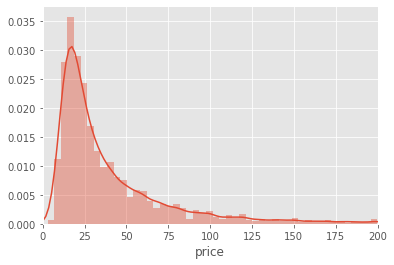

In [0]:
g = sns.distplot(df.price, label='price')
g.set(xlim=(0,200))
plt.show()

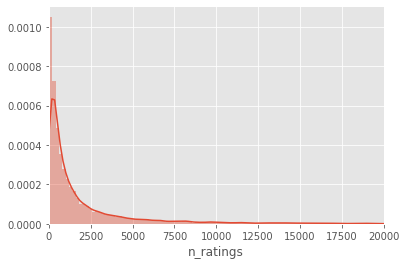

In [0]:
g = sns.distplot(df.n_ratings, bins=100, label='number of ratings')
g.set(xlim=(0,20_000))
plt.show()

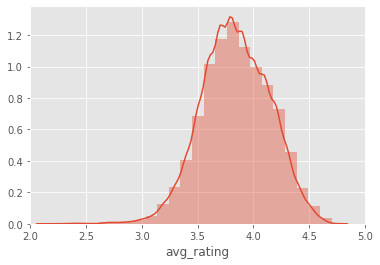

In [0]:
g = sns.distplot(df.avg_rating, bins=24, label='average rating')
g.set(xlim=(2,5))
plt.show()

## Correlations

In [0]:
df.corr()

,price,avg_rating,n_ratings,light_bold,smooth_tannic,dry_sweet,soft_acidic
price,1.000000,0.675766,-0.050533,0.080480,0.063610,-0.029776,0.177038
avg_rating,0.675766,1.000000,0.066303,0.145134,0.059093,0.059416,0.103874
n_ratings,-0.050533,0.066303,1.000000,0.124884,0.092353,0.014382,-0.042698
light_bold,0.080480,0.145134,0.124884,1.000000,0.537904,0.350485,-0.384062
smooth_tannic,0.063610,0.059093,0.092353,0.537904,1.000000,-0.177192,0.325888
dry_sweet,-0.029776,0.059416,0.014382,0.350485,-0.177192,1.000000,-0.360135
soft_acidic,0.177038,0.103874,-0.042698,-0.384062,0.325888,-0.360135,1.000000


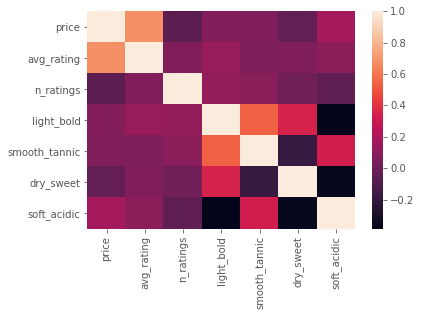

In [0]:
sns.heatmap(df.corr())

In [0]:
vis_only = (df.price<100) & (df.n_ratings <1000)

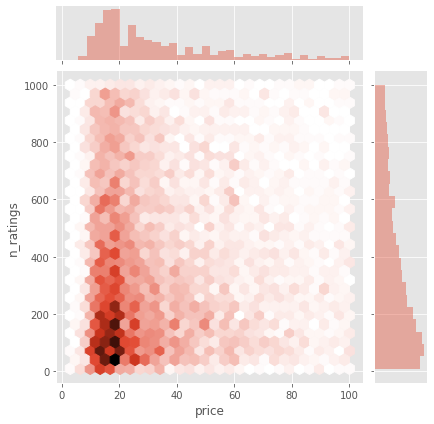

In [0]:
sns.jointplot(df.price[vis_only], df.n_ratings[vis_only], kind="hex")

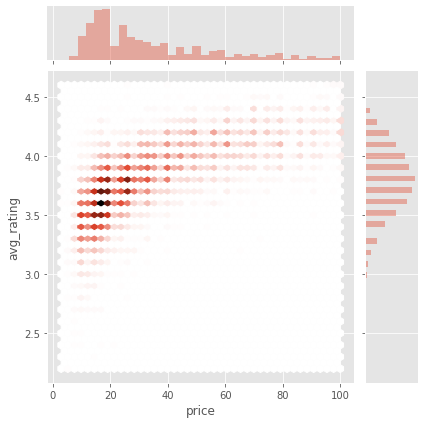

In [0]:
sns.jointplot(df.price[vis_only], df.avg_rating[vis_only], kind="hex")

- Prices correlate with the average rating (67% correlation)
However, there is still lots of variability – a great 4.2-star wine can be easily priced at 20 and at 200 
- Number of ratings correlate slightly negatively with the price, and the relationship looks like the typical inverse price/quantity curve
- NB: non-linear!



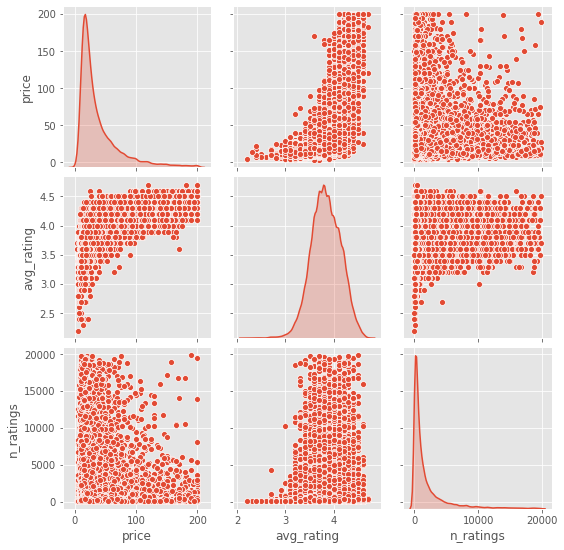

In [0]:
numeric_df = df[['price','avg_rating','n_ratings']]
sns.pairplot(numeric_df,diag_kind="kde")

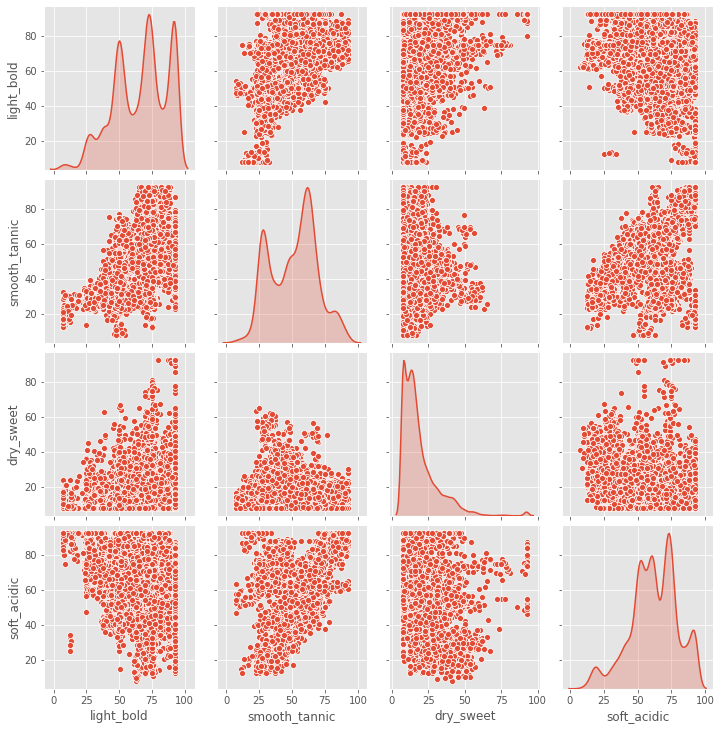

In [0]:
td_df = df[['light_bold', 'smooth_tannic', 'dry_sweet', 'soft_acidic']]
sns.pairplot(td_df,diag_kind="kde")

## Explore Categorical features

In [0]:
for col in CATEGORICAL_COLUMNS:
    print(f'{col}: {len(df[col].unique())} unique')
    print(f'{df[col].value_counts()[:10]}')
    print('-'*20)

wine_type: 7 unique
Red wine          7858
White wine        4034
Sparkling wine     942
Rosé wine          359
Fortified Wine     290
Dessert wine       176
Name: wine_type, dtype: int64
--------------------
wine_style: 267 unique
Californian Pinot Noir            503
Californian Chardonnay            417
Napa Valley Cabernet Sauvignon    340
French Champagne                  286
Californian Cabernet Sauvignon    285
Tuscan Red                        265
Burgundy Côte de Beaune Red       263
Burgundy Côte de Nuits Red        235
Oregon Pinot Noir                 224
Californian Red Blend             216
Name: wine_style, dtype: int64
--------------------
region: 1149 unique
Napa Valley             587
California              507
Willamette Valley       215
Champagne               213
Russian River Valley    212
Toscana                 206
Mendoza                 190
Porto                   167
Rioja                   165
Barolo                  164
Name: region, dtype: int64
---------

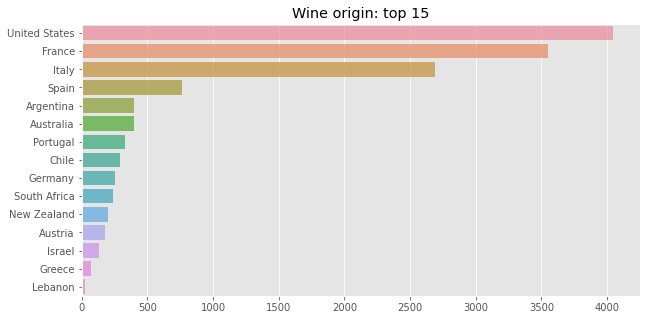

In [0]:
count  = df['country'].value_counts().head(15)
# count = count[:15]
plt.figure(figsize=(10,5))
sns.barplot(count.values, count.index, alpha=0.8, orient='h')
plt.title('Wine origin: top 15')
# plt.ylabel('SKUs', fontsize=12)
# plt.xlabel('country', fontsize=12)
plt.show()

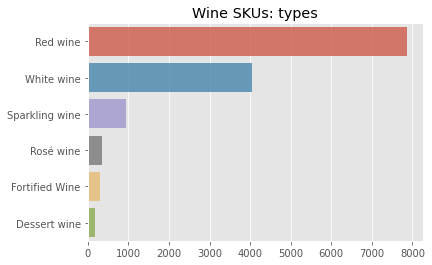

In [0]:
count  = df['wine_type'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(count.values, count.index, alpha=0.8, orient='h')
plt.title('Wine SKUs: types')
# plt.ylabel('SKUs', fontsize=12)
# plt.xlabel('country', fontsize=12)
plt.show()

In [0]:
sns.set_style("darkgrid", {'figure.facecolor': '.96', 'axes.facecolor': '.96', 'axes.edgecolor': '.96', 'grid.color': '0.8',})

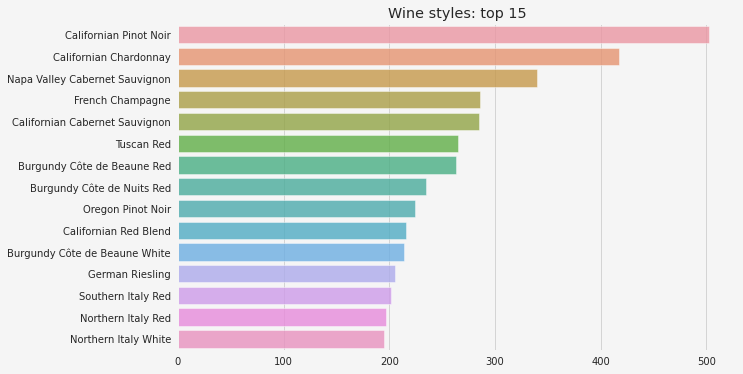

In [0]:
count  = df['wine_style'].value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(count.values, count.index, alpha=0.8, orient='h')
plt.title('Wine styles: top 15')
plt.show()

In [0]:
#  filter top N most frequent wine styles, sort by median prices per wine style
TOP = 10
top_df = df[df['wine_style'].isin(df['wine_style'].value_counts().head(TOP).index)]
med_price = df.groupby('wine_style')['price'].median()
top_df['med']=top_df['wine_style'].apply(lambda x: med_price[x])
top_df.sort_values(by='med', ascending=True, inplace=True)

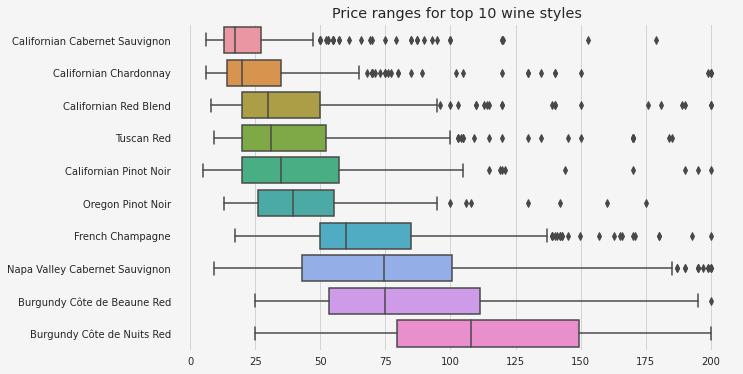

In [0]:
plt.figure(figsize=(10,6))
b =sns.boxplot(y='wine_style', x='price', data=top_df)
plt.title(f'Price ranges for top {TOP} wine styles')

# b.set_xlabel("X Label",fontsize=60)
# b.set_ylabel("Y Label",fontsize=60)
plt.rcParams["axes.labelsize"] = 15
plt.xlabel('')
plt.ylabel('')
plt.show()

In [0]:
#  filter top N most frequent wine styles, sort by median prices per wine style
TOP = 10
top_df = df[df['country'].isin(df['country'].value_counts().head(TOP).index)]
med_price = df.groupby('country')['price'].median()
top_df['med']=top_df['country'].apply(lambda x: med_price[x])
top_df.sort_values(by='med', ascending=True, inplace=True)

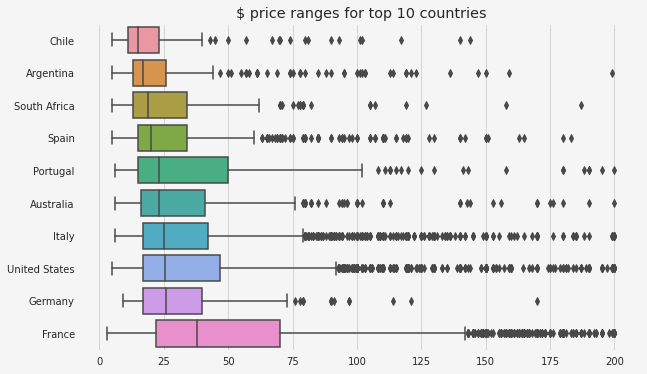

In [0]:
plt.figure(figsize=(10,6))
sns.boxplot(y='country', x='price', data=top_df)
plt.title(f'$ price ranges for top {TOP} countries')
plt.xlabel('')
plt.ylabel('')
plt.show()

## Sales Proxy

- Assumption:  potential demand is proportional to the number of ratings. 
- Then Vivino revenue is proportional to number of ratings x price x commission
- This may be an oversimplification, will need actual sales data to verify 


In [0]:
df['sales_proxy']=df['price']*df['n_ratings']
df.shape

(13666, 12)

In [0]:
# Analyze top 10 countries
top_df = df[df['country'].isin(df['country'].value_counts().head(10).index)]

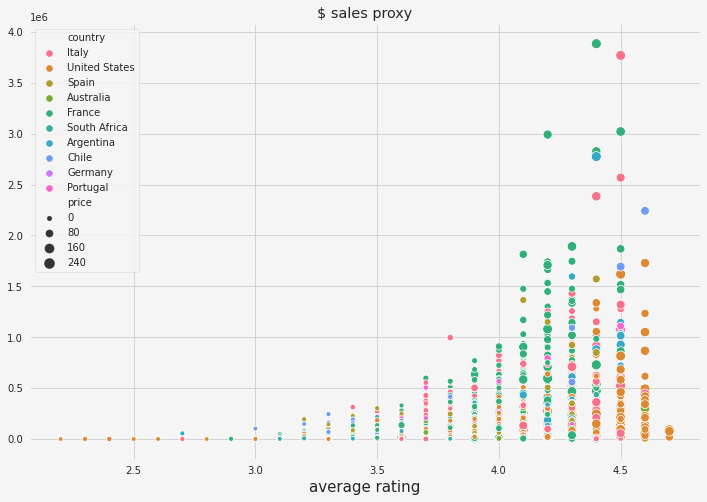

In [0]:
plt.figure(figsize=(12,8))
sns.scatterplot(top_df.avg_rating, top_df.sales_proxy, 
                hue=top_df.country, size=top_df.price, sizes=(20,100))
# ax.xlim(0,40_000)
plt.title('$ sales proxy')
plt.xlabel('average rating')
plt.ylabel('')
plt.show()

Sales proxy is dominated by France and Italy -- together ~60% of the top 'revenue generating' items

In [0]:
top_df.sort_values(by='sales_proxy', ascending=False, inplace=True)
top_df.head(1000)['country'].value_counts()

France           314
Italy            278
United States    174
Spain             79
Argentina         56
Portugal          29
Chile             26
Australia         26
South Africa      16
Germany            2
Name: country, dtype: int64

In [0]:
segment_df = top_df[(top_df.sales_proxy>.5e6)]
segment_df.shape

(303, 12)

In [0]:
segment_df.head(20)

# Modelling Price
- Once the merchant lists the wine at Vivino at a certain price, which ones should we promote to customers as having great value?
- ML: price as a function of all other features


MAE (rather than MSE) must be used as loss whenever possbile - residuals in more expensive items should not be too expensive

## Split, Normalize, Convert to one-hot

In [0]:
numeric_core = ['price', 'avg_rating', 'n_ratings']
numeric_taste = ['light_bold', 'smooth_tannic', 'dry_sweet', 'soft_acidic']
categorical_origin = ['region', 'country']
categorical_type = ['wine_type', 'wine_style']


In [0]:
df_num_core = df.loc[:,numeric_core]
df_num_taste = df.loc[:,numeric_taste]
df_cat_origin = df.loc[:,categorical_origin]
df_cat_type = df.loc[:,categorical_type]


In [0]:
df_cat_origin = pd.get_dummies(df_cat_origin, prefix='', prefix_sep='')
df_cat_type = pd.get_dummies(df_cat_type, prefix='', prefix_sep='')

categorical_origin = list(df_cat_origin.columns)
categorical_type = list(df_cat_type.columns)

In [0]:
df_concat = pd.concat([df_num_core, df_num_taste, df_cat_origin, df_cat_type], axis=1)
df_concat.shape

(13666, 1461)

In [0]:
# TRAIN-TEST SPLIT
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_concat, shuffle=True, test_size=0.2, random_state=7)

y_train = df_train.pop('price')
y_test = df_test.pop('price')
numeric_core.remove('price')

print(df_train.shape)
print(df_test.shape)


(10932, 1460)
(2734, 1460)


In [0]:
print(type(df_train))
print(type(df_test))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [0]:
# BUILD FEATURE GROUPS 
df_train_num_core = df_train.loc[:,numeric_core]
df_train_num_taste = df_train.loc[:,numeric_taste]
df_train_cat_origin = df_train.loc[:,categorical_origin]
df_train_cat_type = df_train.loc[:,categorical_type]

df_test_num_core = df_test.loc[:,numeric_core]
df_test_num_taste = df_test.loc[:,numeric_taste]
df_test_cat_origin = df_test.loc[:,categorical_origin]
df_test_cat_type = df_test.loc[:,categorical_type]


In [0]:
# 3. NUMERIC: NORMALIZE & FILLNA
from sklearn.preprocessing import StandardScaler

# scalers fit on train dfs ONLY
scaler = StandardScaler()
scaler.fit(df_train_num_core.values)
df_train_num_core[numeric_core] = scaler.transform(df_train_num_core.values)
df_test_num_core[numeric_core] = scaler.transform(df_test_num_core.values)

# scalers fit on train dfs ONLY
scaler = StandardScaler()
scaler.fit(df_train_num_taste.values)
df_train_num_taste[numeric_taste] = scaler.transform(df_train_num_taste.values)
df_test_num_taste[numeric_taste] = scaler.transform(df_test_num_taste.values)

# fill NaN in the taste dimensions (0 is the normalized mean)
df_train_num_taste.fillna(value=0, inplace=True)
df_test_num_taste.fillna(value=0, inplace=True)

## Permutations of feature groups

In [0]:
# Build seven feature groups from the following columns:
train_dfs=[]
# pure numeric combinations
train_dfs.append(df_train_num_core)
train_dfs.append(pd.concat([df_train_num_core, df_train_num_taste], axis=1))
# numeric plus wine origin
train_dfs.append(pd.concat([df_train_num_core, df_train_cat_origin], axis=1))
train_dfs.append(pd.concat([df_train_num_core, df_train_num_taste, df_train_cat_origin], axis=1))
# numeric plus wine type
train_dfs.append(pd.concat([df_train_num_core, df_train_cat_type], axis=1))
train_dfs.append(pd.concat([df_train_num_core, df_train_num_taste, df_train_cat_type], axis=1))
# all 4 groups combined
train_dfs.append(pd.concat([df_train_num_core, df_train_num_taste, df_train_cat_origin, df_train_cat_type], axis=1))

In [0]:
test_dfs=[]
# pure numeric combinations
test_dfs.append(df_test_num_core)
test_dfs.append(pd.concat([df_test_num_core, df_test_num_taste], axis=1))
# numeric plus wine origin
test_dfs.append(pd.concat([df_test_num_core, df_test_cat_origin], axis=1))
test_dfs.append(pd.concat([df_test_num_core, df_test_num_taste, df_test_cat_origin], axis=1))
# numeric plus wine type
test_dfs.append(pd.concat([df_test_num_core, df_test_cat_type], axis=1))
test_dfs.append(pd.concat([df_test_num_core, df_test_num_taste, df_test_cat_type], axis=1))
# all 4 groups combined
test_dfs.append(pd.concat([df_test_num_core, df_test_num_taste, df_test_cat_origin, df_test_cat_type], axis=1))

In [0]:
# Inspect the normalized clean features before feeding into ML
test_dfs[6].head(5)

,avg_rating,n_ratings,light_bold,smooth_tannic,dry_sweet,soft_acidic,Abruzzo,Achaia,Aconcagua Costa,Aconcagua Valley,Adelaide Hills,Aglianico del Vulture,Agrelo,Albana di Romagna,Alella,Alentejano,Alentejo,Alexander Valley,Alexandra,Alghero,Alicante,Almansa,Aloxe-Corton,Aloxe-Corton 1er Cru 'Clos du Chapître',Aloxe-Corton 1er Cru 'Les Chaillots',Aloxe-Corton 1er Cru 'Les Valozières',Aloxe-Corton Premier Cru,Alpilles,Alsace,Alsace Grand Cru,Alsace Grand Cru 'Brand',Alsace Grand Cru 'Eichberg',Alsace Grand Cru 'Hengst',Alsace Grand Cru 'Kaefferkopf',Alsace Grand Cru 'Mambourg',Alsace Grand Cru 'Muenchberg',Alsace Grand Cru 'Pfersigberg',Alsace Grand Cru 'Pfingstberg',Alsace Grand Cru 'Rosacker',Alsace Grand Cru 'Schlossberg',...,Spanish Albariño,Spanish Cabernet Sauvignon,Spanish Cava,Spanish Chardonnay,Spanish Grenache,Spanish Mencia,Spanish Merlot,Spanish Monastrell,Spanish Montsant Red,Spanish Pedro Ximenez,Spanish Priorat Red,Spanish Red,Spanish Rhône Blend Red,Spanish Ribera Del Duero Red,Spanish Rioja Red,Spanish Rioja White,Spanish Sherry,Spanish Sparkling,Spanish Syrah,Spanish Tempranillo,Spanish Toro Red,Spanish Verdejo,Swiss Merlot,Swiss Pinot Noir,Tawny Port,Tuscan Red,Upper Loire Red,Upper Loire White,Uruguay Tannat,Vintage Port,Washington State Cabernet Sauvignon,Washington State Chardonnay,Washington State Gewürztraminer,Washington State Merlot,Washington State Pinot Noir,Washington State Red Blend,Washington State Riesling,Washington State Sauvignon Blanc,Washington State Syrah,White Port
wine_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2050095,0.206066,-0.067494,0.559559,0.337728,-0.297395,-0.035360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
932,-0.125606,-0.064200,1.313121,0.000000,1.237983,-0.893195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1162375,-0.788950,-0.326421,0.830587,0.812182,-0.070514,-0.259444,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2717658,1.201082,-0.607418,-1.606727,-1.298659,0.009271,0.674797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1233865,0.206066,-0.583370,1.313121,-0.649996,-0.297454,-0.700855,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## OLS and Ridge

In [0]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error


In [0]:
def evaluate_model_linear(x_train, y_train, x_test, y_test):
    
    x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values
            
    tic = time.time()
    model = LinearRegression().fit(x_train, y_train)
    
    toc = time.time()
    print(f'Model built in {toc-tic:.1f} sec')
    
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)

    rsquared_train = r2_score(y_train, y_hat_train)
    rsquared_test = r2_score(y_test, y_hat_test)

    mae_train = mean_absolute_error(y_train, y_hat_train)
    mae_test = mean_absolute_error(y_test, y_hat_test)

    print(rsquared_train, rsquared_test, mae_train, mae_test)
    return model


In [0]:
for build in range(len(train_dfs)):
    metrics = evaluate_model_linear(train_dfs[build], y_train, test_dfs[build], y_test)
    print(metrics)


In [0]:
def evaluate_model_ridge(x_train, y_train, x_test, y_test, alpha=1):
    
    x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values
            
    tic = time.time()
    model = Ridge(alpha=alpha).fit(x_train, y_train)
    
    toc = time.time()
    print(f'Model built in {toc-tic:.1f} sec')
    
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)

    rsquared_train = r2_score(y_train, y_hat_train)
    rsquared_test = r2_score(y_test, y_hat_test)

    mae_train = mean_absolute_error(y_train, y_hat_train)
    mae_test = mean_absolute_error(y_test, y_hat_test)

    print(rsquared_train, rsquared_test, mae_train, mae_test)
    return model


In [0]:
for build in range(len(train_dfs)):
    metrics = evaluate_model_ridge(train_dfs[build], y_train, test_dfs[build], y_test, alpha=1)
    print(metrics)


## Almost-linear ReLU and DNN

In [0]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
print(tf.__version__)

2.2.0-rc3


Using TensorFlow backend.


In [0]:
def evaluate_model_relu(x_train, y_train, x_test, y_test, 
                        epochs, lr, reg_lambda):
    
    x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

    model = keras.Sequential([
        layers.Dense(1, 
                     activation='relu', 
                     kernel_regularizer=regularizers.l2(reg_lambda),
                     input_shape=[x_train.shape[1]]) 
    ])

    model.compile(loss='mae',
                    optimizer=tf.keras.optimizers.Adam(lr),
                    metrics=['mae'])

    history = model.fit(x_train, y_train,
                        epochs=epochs, 
                        validation_split = 0.2, 
                        verbose=1)            ,

    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)

    rsquared_train = r2_score(y_train, y_hat_train)
    rsquared_test = r2_score(y_test, y_hat_test)

    mae_train = mean_absolute_error(y_train, y_hat_train)
    mae_test = mean_absolute_error(y_test, y_hat_test)

    print(rsquared_train, rsquared_test, mae_train, mae_test)
    return model


In [0]:
build = 6
x_train, y_train, x_test, y_test = train_dfs[build], y_train, test_dfs[build], y_test
relu_model = evaluate_model_relu(x_train, y_train, x_test, y_test, 
                        epochs=100,
                        lr=0.005,
                        reg_lambda=0)

In [0]:
def evaluate_model_one_layer(x_train, y_train, x_test, y_test, 
                        epochs=1_000,
                        lr=0.001,
                        reg_lambda=0):
    
    x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

    model = keras.Sequential([
        layers.Dense(64, 
                     activation='relu', 
                     kernel_regularizer=regularizers.l2(reg_lambda),
                     input_shape=[x_train.shape[1]]), 
        layers.Dense(1, activation='relu'),
    ])

    model.compile(loss='mae',
                    optimizer=tf.keras.optimizers.Adam(lr),
                    metrics=['mae'])

    history = model.fit(x_train, y_train,
                        epochs=epochs, 
                        validation_split = 0.2, 
                        verbose=1)            ,

    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)

    rsquared_train = r2_score(y_train, y_hat_train)
    rsquared_test = r2_score(y_test, y_hat_test)

    mae_train = mean_absolute_error(y_train, y_hat_train)
    mae_test = mean_absolute_error(y_test, y_hat_test)
    
    print(rsquared_train, rsquared_test, mae_train, mae_test)
    return model


In [0]:
build = 6
x_train, y_train, x_test, y_test = train_dfs[build], y_train, test_dfs[build], y_test
dnn_model = evaluate_model_one_layer(x_train, y_train, x_test, y_test, 
                        epochs=100,
                        lr=0.001,
                        reg_lambda=0.01)


In [0]:
metrics = {'ols':  [0.7083860808785647, -2.345876962740814e+20, 12.061223232176706, 44033333539.87317],
'ridge': [0.6988013463747551, 0.6586959788482087, 12.509817705387233, 13.668472629600492],
'relu' : [0.6239524674454986, 0.6124797813462132, 12.14587594396066, 12.880138902106072],
'dnn':[0.7442405476366483, 0.7564031100435143, 9.923902117367676, 10.243977203369141]}

In [0]:
metrics_df = pd.DataFrame(data=metrics, index=['rsquared_train', 'rsquared_test', 'mae_train', 'mae_test'])

- DNN clearly wins both at R squared and at MAE out-of-sample!
- the only real competition may come from XGBoost

In [0]:
metrics_df

,ols,ridge,relu,dnn
rsquared_train,7.083861e-01,0.698801,0.623952,0.744241
rsquared_test,-2.345877e+20,0.658696,0.612480,0.756403
mae_train,1.206122e+01,12.509818,12.145876,9.923902
mae_test,4.403333e+10,13.668473,12.880139,10.243977


## Predict

In [0]:
y_hat_test = np.squeeze(dnn_model.predict(x_test))

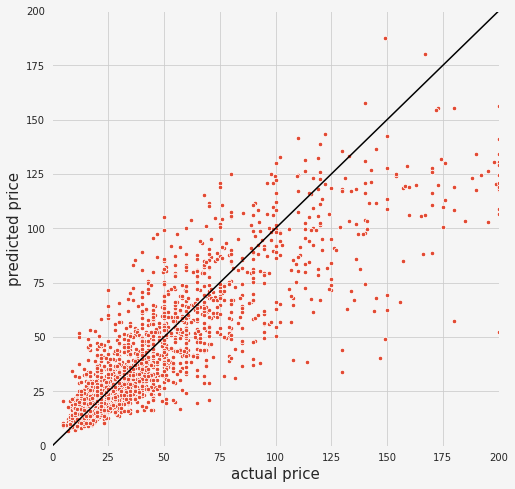

In [0]:
plt.figure(figsize=(8,8))
g = sns.scatterplot(y_test, y_hat_test, s=20)
g.set(xlim=(0,200), ylim=(0,200))
plt.plot((0,200),(0,200), 'k')
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.show()

- Residuals have a nice normal-like shape
- Potential next steps: one-by-one large error analysis,  due test of normality

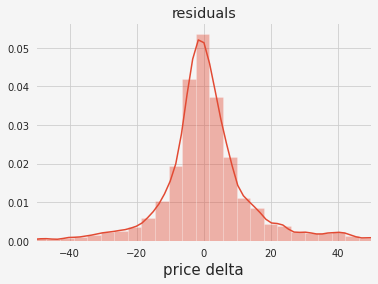

In [0]:
g = sns.distplot(y_test-y_hat_test, label='price')
g.set(xlim=(-50,50))

plt.title('residuals')
plt.xlabel('price delta')
plt.show()

In [0]:
rel_error = (y_hat_test-y_test)/y_test

In [0]:
display_stats(rel_error, quantiles=[0.1, 0.5, 0.9], pct_values=[0.1, 0.2])

Length    2,734
Min--Max  -0.7390373211287518--3.3286394337199945
Mean      0.06
Median    -0.003974401053226988
St.dev    0.38
Quantiles:  {0.1: -0.33535351086913145, 0.5: -0.003974401053226988, 0.9: 0.4920314535316729}
Percentiles:  {0.1: 62.1, 0.2: 72.89}


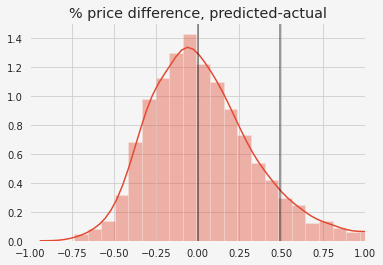

In [0]:
# >>> POTENTIAL GREAT DEALS
# those that the model priced much higher than the actual listed price
# identify top-10% of such price discrepancies for potential human verification

TOP = 0.1

g = sns.distplot(rel_error)
g.set(xlim=(-1,1))
plt.title('% price difference, predicted-actual')
plt.axvline(0, color='k', alpha=0.5)
plt.axvline(np.quantile(rel_error, (1-TOP)), color='k', alpha=0.5)
plt.xlabel('')
plt.show()

In [0]:
TOP = 0.1
v = np.quantile(rel_error, (1-TOP))

In [0]:
rel_v = rel_error[rel_error>v]

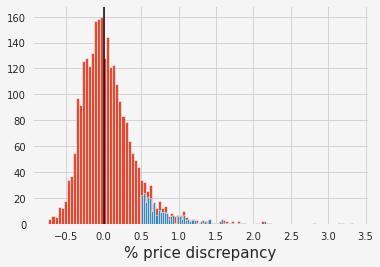

In [0]:

g = plt.hist(rel_error, bins=100)
g = plt.hist(rel_v, bins=100)
plt.xlim=(-1,1)
plt.axvline(0, color='k')
# plt.axvline(np.quantile(rel_error, (1-TOP)), color='k', alpha=0.5)
plt.xlabel('% price discrepancy')
plt.show()